# FLOWER RECOGNITION KAGGLE CNN KERAS

#### 1 ) Importing Various Modules.

#### 2 ) Preparing the Data

#### 3 ) Modelling

#### 4 ) Evaluating the Model Performance

## 1 ) Importing Various Modules.

In [1]:
# data visualisation and manipulation
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,Adamax,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [2]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'


In [3]:
def assign_label(img,flower_type):
    return flower_type
    

In [4]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [5]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 792/792 [00:10<00:00, 73.91it/s] 


792


In [6]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 760/760 [00:07<00:00, 98.69it/s] 


1552


In [7]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 1020/1020 [00:16<00:00, 60.55it/s]


2572


In [8]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1062/1062 [00:08<00:00, 119.14it/s]


3634


In [9]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 876/876 [00:03<00:00, 225.16it/s]


4510


## 2.2 ) Visualizing some Random Images

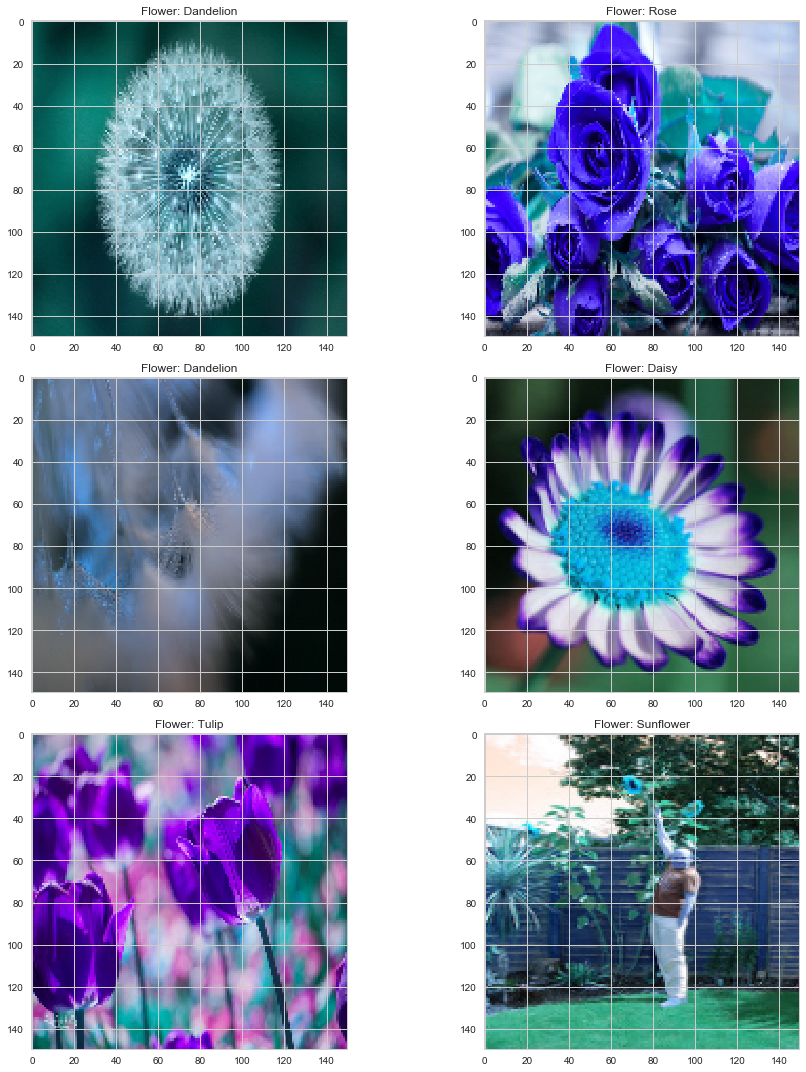

In [10]:
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [11]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [12]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [13]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [14]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [15]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [17]:
model.compile(optimizer=Adamax(lr=0.002),loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [19]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
26/26 [==============================] - ETA: 36:36 - loss: 1.6167 - acc: 0.12 - ETA: 17:49 - loss: 1.9900 - acc: 0.18 - ETA: 11:32 - loss: 1.8939 - acc: 0.20 - ETA: 8:23 - loss: 1.8250 - acc: 0.2070 - ETA: 6:29 - loss: 1.7803 - acc: 0.232 - ETA: 5:13 - loss: 1.7523 - acc: 0.233 - ETA: 4:18 - loss: 1.7311 - acc: 0.225 - ETA: 3:36 - loss: 1.7142 - acc: 0.227 - ETA: 3:04 - loss: 1.7019 - acc: 0.221 - ETA: 2:38 - loss: 1.6911 - acc: 0.224 - ETA: 2:16 - loss: 1.6819 - acc: 0.225 - ETA: 1:58 - loss: 1.6733 - acc: 0.226 - ETA: 1:42 - loss: 1.6690 - acc: 0.221 - ETA: 1:28 - loss: 1.6617 - acc: 0.221 - ETA: 1:16 - loss: 1.6562 - acc: 0.218 - ETA: 1:06 - loss: 1.6503 - acc: 0.223 - ETA: 56s - loss: 1.6443 - acc: 0.232 - ETA: 48s - loss: 1.6370 - acc: 0.23 - ETA: 40s - loss: 1.6291 - acc: 0.24 - ETA: 33s - loss: 1.6248 - acc: 0.24 - ETA: 26s - loss: 1.6174 - acc: 0.25 - ETA: 20s - loss: 1.6094 - acc: 0.25 - ETA: 14s - loss: 1.6039 - acc: 0.26 - ETA: 9s - loss: 1.5931 - acc: 0.2705 - E

26/26 [==============================] - ETA: 30s - loss: 0.8114 - acc: 0.71 - ETA: 28s - loss: 0.7371 - acc: 0.73 - ETA: 27s - loss: 0.7727 - acc: 0.70 - ETA: 26s - loss: 0.7704 - acc: 0.71 - ETA: 25s - loss: 0.7835 - acc: 0.70 - ETA: 24s - loss: 0.7852 - acc: 0.70 - ETA: 22s - loss: 0.7754 - acc: 0.70 - ETA: 21s - loss: 0.7697 - acc: 0.70 - ETA: 20s - loss: 0.7718 - acc: 0.70 - ETA: 19s - loss: 0.7675 - acc: 0.70 - ETA: 18s - loss: 0.7632 - acc: 0.70 - ETA: 16s - loss: 0.7722 - acc: 0.70 - ETA: 15s - loss: 0.7793 - acc: 0.70 - ETA: 13s - loss: 0.7727 - acc: 0.70 - ETA: 12s - loss: 0.7693 - acc: 0.70 - ETA: 11s - loss: 0.7609 - acc: 0.71 - ETA: 10s - loss: 0.7617 - acc: 0.71 - ETA: 9s - loss: 0.7645 - acc: 0.7113 - ETA: 8s - loss: 0.7686 - acc: 0.710 - ETA: 7s - loss: 0.7711 - acc: 0.707 - ETA: 5s - loss: 0.7735 - acc: 0.706 - ETA: 4s - loss: 0.7785 - acc: 0.704 - ETA: 3s - loss: 0.7755 - acc: 0.704 - ETA: 2s - loss: 0.7747 - acc: 0.703 - ETA: 1s - loss: 0.7721 - acc: 0.704 - 35s 1s/s

26/26 [==============================] - ETA: 13s - loss: 0.4941 - acc: 0.81 - ETA: 20s - loss: 0.5719 - acc: 0.77 - ETA: 22s - loss: 0.6321 - acc: 0.76 - ETA: 22s - loss: 0.6161 - acc: 0.76 - ETA: 22s - loss: 0.6146 - acc: 0.75 - ETA: 21s - loss: 0.6060 - acc: 0.76 - ETA: 21s - loss: 0.6021 - acc: 0.76 - ETA: 20s - loss: 0.6037 - acc: 0.76 - ETA: 19s - loss: 0.6036 - acc: 0.76 - ETA: 18s - loss: 0.6048 - acc: 0.76 - ETA: 17s - loss: 0.6086 - acc: 0.76 - ETA: 16s - loss: 0.6082 - acc: 0.76 - ETA: 14s - loss: 0.6111 - acc: 0.76 - ETA: 13s - loss: 0.6254 - acc: 0.76 - ETA: 12s - loss: 0.6172 - acc: 0.76 - ETA: 11s - loss: 0.6181 - acc: 0.76 - ETA: 10s - loss: 0.6117 - acc: 0.76 - ETA: 9s - loss: 0.6067 - acc: 0.7718 - ETA: 8s - loss: 0.6099 - acc: 0.771 - ETA: 7s - loss: 0.6009 - acc: 0.774 - ETA: 5s - loss: 0.6049 - acc: 0.773 - ETA: 4s - loss: 0.6067 - acc: 0.773 - ETA: 3s - loss: 0.6033 - acc: 0.774 - ETA: 2s - loss: 0.6017 - acc: 0.775 - ETA: 1s - loss: 0.5994 - acc: 0.776 - 35s 1s/s

26/26 [==============================] - ETA: 30s - loss: 0.4930 - acc: 0.75 - ETA: 28s - loss: 0.4939 - acc: 0.76 - ETA: 27s - loss: 0.4859 - acc: 0.78 - ETA: 26s - loss: 0.4610 - acc: 0.79 - ETA: 25s - loss: 0.4582 - acc: 0.81 - ETA: 24s - loss: 0.4552 - acc: 0.81 - ETA: 22s - loss: 0.4548 - acc: 0.81 - ETA: 21s - loss: 0.4560 - acc: 0.81 - ETA: 20s - loss: 0.4697 - acc: 0.81 - ETA: 19s - loss: 0.4861 - acc: 0.81 - ETA: 18s - loss: 0.4819 - acc: 0.81 - ETA: 16s - loss: 0.4851 - acc: 0.81 - ETA: 15s - loss: 0.4936 - acc: 0.81 - ETA: 14s - loss: 0.4956 - acc: 0.81 - ETA: 12s - loss: 0.4972 - acc: 0.81 - ETA: 11s - loss: 0.5027 - acc: 0.80 - ETA: 10s - loss: 0.5051 - acc: 0.80 - ETA: 9s - loss: 0.5131 - acc: 0.8047 - ETA: 8s - loss: 0.5108 - acc: 0.806 - ETA: 6s - loss: 0.5107 - acc: 0.805 - ETA: 5s - loss: 0.5147 - acc: 0.805 - ETA: 4s - loss: 0.5149 - acc: 0.806 - ETA: 3s - loss: 0.5128 - acc: 0.807 - ETA: 2s - loss: 0.5133 - acc: 0.807 - ETA: 1s - loss: 0.5065 - acc: 0.810 - 35s 1s/s

<h1>4 ) Evaluating the Model Performance</h1>

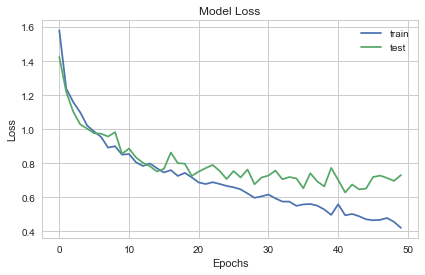

In [20]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

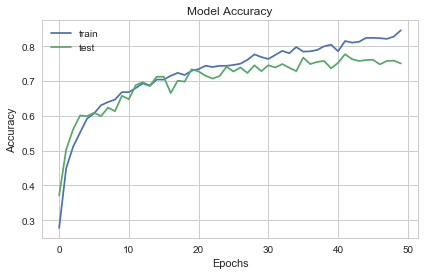

In [21]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
